# Load Data
Note: Data should be stored in the relative path `../data/`. 

There are a total of 3 files - `restaurants` and `reviews` are scraped from the [Burpple website](www.burpple.com), whereas the `restaurant_reviews_withsentiment_null` is based from the `reviews` file, and contains additional sentiment scores and has been somewhat processed (e.g. review title and body are combined, changed to lower case).

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import pickle

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter

import re
# import spacy
# nlp = spacy.load("en_core_web_sm")

In [8]:
## Raw Data (scraped)
reviews = pickle.load(open('../data/restaurant_reviews.pkl','rb'))
restaurants = pickle.load(open('../data/restaurants.pkl','rb'))
# restaurants.rename(columns={'index':'RestaurantName'}, inplace=True)

## Processed Data (with sentiment scores)
df = pd.read_csv('../data/restaurant_reviews_withsentiment_null.csv')
df_backup = df.copy()

# Raw Data
1. `restaurants` data was scrapped from the "Search" page of Burpple. An empty search string returned restaurants that were sorted by 'Trending'. BeautifulSoup4 package was used to scrape through about 100 pages containing 12 restaurants each. This gives us a total of 1164 restaurants.
2. `reviews` data was then scrapped from each restaurant on the list from `restaurants` based on the `Link`. For this, Selenium had to be used to get the reviews page after page. 

## Reviews Dataset - Columns
All values are taken as of the time and date of scraping (4th November 2019).

|Column Name|Column Description|
|:---|:---|
Title|Review Title
Body|The content of the Review.*
Reviewer|Name of person who made the Review
Reviewer_ID|Indexed ID of the `Reviewer` (Anoymization).
Reviewer_Level| Level of the `Reviewer`, based on number of reviews written
Reviewer_NumReviews| Number of Reviews written by the `Reviewer`
ReviewDateTime|DateTime of the Review
Restaurant|URL Link of the restaurant

In [10]:
reviews.describe(include='all')

,Title,Body,Reviewer,Reviewer_Level,Reviewer_NumReviews,ReviewDateTime,Restaurant
count,63921,63921,63921,63921,63921,63921,63921
unique,57256,57735,6037,11,975,20297,1114
top,Flat White,,Burpple Guides,10,1,4d ago,/sunday-folks
freq,81,5513,825,11075,882,128,684


### Review Recency
When were reviews posted?

In [250]:
reviews['Year'] = reviews.ReviewDateTime.str.extract(pat='([0-9]{4})')
reviews.loc[reviews['Year'].isna(),'Year'] = '2019' # if year is not stated, it is this year.

In [265]:
reviews.loc[reviews.Year == '2017',['ReviewDateTime','Year']]

,ReviewDateTime,Year
82,"Dec 29, 2017",2017
83,"Dec 13, 2017",2017
84,"Dec 5, 2017",2017
85,"Nov 22, 2017",2017
86,"Nov 22, 2017",2017
87,"Nov 21, 2017",2017
88,"Nov 21, 2017",2017
89,"Nov 21, 2017",2017
96,"Nov 20, 2017",2017
97,"Oct 5, 2017",2017


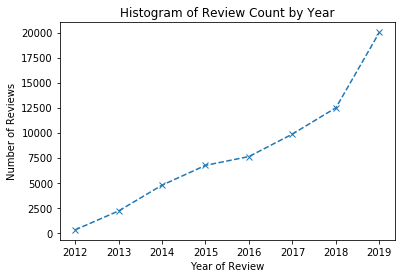

In [278]:
plt.plot(reviews.Year.value_counts().sort_values(), 'x--')
plt.title('Histogram of Review Count by Year')
plt.xlabel('Year of Review')
plt.ylabel('Number of Reviews')
plt.show()

## Restaurant Dataset - Columns
All values are taken as of the time and date of scraping (4th November 2019).

|Column Name|Column Description|
|:---|:---|
RestaurantName|Name of the restaurant
Categories|Categories of the restaurant as tagged by Burpple
Latitude|Latitude of the restaurant exact location
Link|URL link of the restaurant
Location|Neighborhood the restaurant is located in
Longitude|Longitude of the restaurant exact location
NumReviews|Number of Reviews the restaurant has in total
PriceRange|Price range of the restaurant as declared by the owners
Tags|Any additional tags that the restaurant/Burpple has assigned

In [9]:
restaurants.describe(include='all')

,index,Categories,Latitude,Link,Location,Longitude,NumReviews,PriceRange,Tags
count,1164,1164,1164.000000,1164,1164,1164.000000,1164.000000,1164,1164
unique,1164,855,NaN,1164,92,NaN,NaN,30,37
top,Dona Manis Cake Shop,[Hawker Food],NaN,/collins-grille-bento-11,Tanjong Pagar,NaN,NaN,~$10/pax,[]
freq,1,48,NaN,1,93,NaN,NaN,238,514
mean,NaN,NaN,1.309620,NaN,NaN,103.849642,85.835911,NaN,NaN
std,NaN,NaN,0.030211,NaN,NaN,0.042827,132.997364,NaN,NaN
min,NaN,NaN,1.243299,NaN,NaN,103.703916,0.000000,NaN,NaN
25%,NaN,NaN,1.289748,NaN,NaN,103.836273,11.000000,NaN,NaN
50%,NaN,NaN,1.302166,NaN,NaN,103.848334,36.000000,NaN,NaN
75%,NaN,NaN,1.322326,NaN,NaN,103.859283,94.000000,NaN,NaN


### Restaurant Distribution
1. By PriceRange
2. By Location
3. By Categories

In [105]:
restaurants['PriceRange_num'] = restaurants.PriceRange.str.extract(pat='([0-9]{1,})')
restaurants['PriceRange_num'] = restaurants['PriceRange_num'].astype(int)

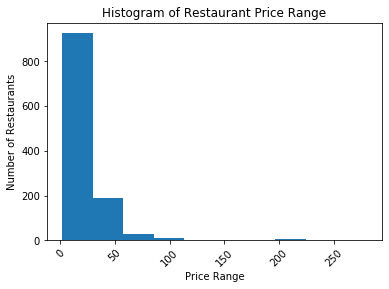

In [107]:
plt.hist(restaurants.PriceRange_num)
plt.xticks(rotation=45)
plt.title('Histogram of Restaurant Price Range')
plt.xlabel('Price Range')
plt.ylabel('Number of Restaurants')
plt.show()

In [148]:
sg_mask = np.array(Image.open("sg_map.png"))
text = restaurants.Location.tolist()
wordcloud = WordCloud(background_color="white", mask=sg_mask,contour_width=3, contour_color='green').generate(' '.join(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Scraping Efficiency
Since there was some error catching in the scraping (ignore if Timeout, page crash, etc), not all the reviews of each restaurant was captured.

In [12]:
scraped_reviews = pd.DataFrame(data=reviews.Restaurant.value_counts())

scrape_check = pd.merge(left=scraped_reviews, 
         right=restaurants[['Link','NumReviews']], 
         how='outer', 
         left_index=True, 
         right_on='Link')
scrape_check = scrape_check.set_index('Link')
scrape_check.columns=['Scraped','Actual']

In [13]:
scrape_check.head()

,Scraped,Actual
Link,,
/sunday-folks,684.0,971
/lolas-cafe,541.0,818
/one-man-coffee,528.0,677
/oriole-cafe-bar,526.0,810
/koh-grill-sushi-bar,474.0,782


In [14]:
# Number of restaurants that did not get scraped.
len(scrape_check[scrape_check.Scraped.isna()])

50

In [15]:
# Average scraping efficiency for each restaurant.
scrape_check['Perc_Scraped'] = scrape_check.Scraped / scrape_check.Actual * 100
scrape_check.Perc_Scraped.mean()

86.85934622788407

In [16]:
scrape_check.Perc_Scraped.std()

16.33076301530308

Since, overall we managed to get sufficient data from the scraping, we can just ignore those which we did not manage to catch.

# Processed Data 
This is based on the final table with the sentiment results. (Contains the original scraped data as well).

## Columns
All values are taken as of the time and date of scraping (4th November 2019).

|Column Name|Column Description|
|:---|:---|
Title|Review Title
Body|The content of the Review.*
Reviewer|Name of person who made the Review
Reviewer_ID|Indexed ID of the `Reviewer` (Anoymization).
Reviewer_Level| Level of the `Reviewer`, based on number of reviews written
Reviewer_NumReviews| Number of Reviews written by the `Reviewer`
ReviewDateTime|DateTime of the Review
RestaurantName|Name of the restaurant
Restaurant|URL Link of the restaurant
Review|Combined `Title` + `Body` text.
Food|Food items extracted from `Review`
RestaurantReview|Sentences of the `Review` that do not contain a `Food` item
FoodReview|Sentences of the `Review` that contain a `Food` item
RestaurantFeature(spacy)|Sentiment Score of the `RestaurantReview` using Spacy
FoodFeature(spacy)|Sentiment Score of the `FoodReview` using Spacy
RestaurantFeature(online)|Sentiment Score of the `RestaurantReview` using [another model]()
FoodFeature(online)|Sentiment Score of the `FoodReview` using the other model (above)
RestaurantSentimentProba|The probability of the `OverallSentimentClass` based on the `RestaurantReview` 
FoodSentimentProba|The probability of the `OverallSentimentClass` based on the `FoodReview` 
OverallSentimentClass|Sentiment Class of the entire `Review` (Positive = 1, Negative = 0)
Cuisine|Predicted Cuisine of the restaurant|


*If there was no content given (i.e. `Review == ''`) then the Body value for that review will be converted to `NaN`.

In [17]:
df.describe(include='all')

,Title,Body,Reviewer,Reviewer_ID,Reviewer_Level,Reviewer_NumReviews,ReviewDateTime,RestaurantName,Restaurant,Review,...,RestaurantReview,FoodReview,RestaurantFeature(spacy),FoodFeature(spacy),RestaurantFeature(online),FoodFeature(online),RestaurantSentimentProba,FoodSentimentProba,OverallSentimentClass,Cuisine
count,63921,58408,63921,63921,63096.000000,63096.000000,63921,63921,63921,63921,...,54455,57904,47099,53891,45467,51129,63921.000000,63921.000000,63921.000000,59858
unique,57256,57726,6037,6037,NaN,NaN,20297,1114,1114,63570,...,52529,57304,39494,49494,14710,32341,NaN,NaN,NaN,9
top,Flat White,"Ok, that's all.",Burpple Guides,U0008,NaN,NaN,4d ago,Sunday Folks,/sunday-folks,👍.,...,😋,#NAME?,good,fried,good,hot,NaN,NaN,NaN,western
freq,81,57,825,825,NaN,NaN,128,684,684,21,...,69,17,445,144,3881,1101,NaN,NaN,NaN,17010
mean,NaN,NaN,NaN,NaN,7.045344,973.658774,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.824981,0.854035,0.976236,NaN
std,NaN,NaN,NaN,NaN,2.364882,1200.167733,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.166715,0.128991,0.152313,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,0.000732,0.000000,NaN
25%,NaN,NaN,NaN,NaN,5.000000,97.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.760298,0.768350,1.000000,NaN
50%,NaN,NaN,NaN,NaN,7.000000,446.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.854036,0.887504,1.000000,NaN
75%,NaN,NaN,NaN,NaN,9.000000,1416.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.955794,0.952244,1.000000,NaN


## Reviewers

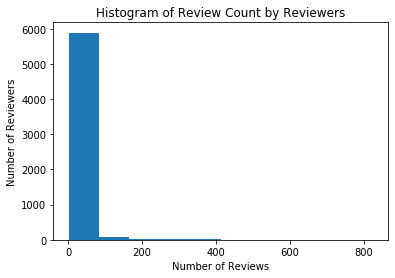

In [29]:
reviewers_reviewcount = df.groupby('Reviewer').Title.count().sort_values(ascending=False)
plt.hist(reviewers_reviewcount)
plt.title('Histogram of Review Count by Reviewers')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Reviewers')
plt.show()

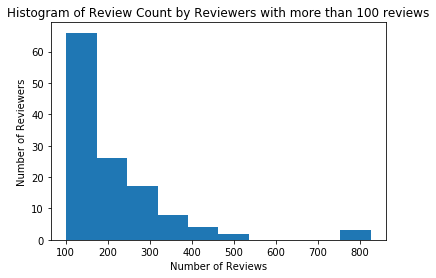

In [30]:
# zoom in
plt.hist(reviewers_reviewcount[reviewers_reviewcount > 100])
plt.title('Histogram of Review Count by Reviewers with more than 100 reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Reviewers')
plt.show()

As can be seen, the number of reviews per reviewer is highly skewed. Since most of our reviews actually come from a minority of reviewers, our model and recommendation engine may bias towards the preferences of these reviewers. 

However it is also important to note that these reviewers with many reviews tend to write longer, more 'quality' reviews than those who only post occasionally. This is likely encouraged by Burpple's 'loyalty' programme for Burpplers - the more you write, the more 'rewards' you get in terms of invitations to food tastings, features on the Burpple website and thus more viewership for your blog posts. 

In [22]:
df['ReviewLength'] = df.Review.apply(len)
df['FoodList'] = df.Food.str.split(',')
df['RestaurantFeatures'] = df['RestaurantFeature(online)'].str.split(',')
df['FoodFeatures'] = df['FoodFeature(online)'].str.split(',')

df['FoodList'] = df['FoodList'].apply(lambda d: d if isinstance(d, list) else [])
df['RestaurantFeatures'] = df['RestaurantFeatures'].apply(lambda d: d if isinstance(d, list) else [])
df['FoodFeatures'] = df['FoodFeatures'].apply(lambda d: d if isinstance(d, list) else [])

In [23]:
user_reviews = df.groupby('Reviewer').agg({'Reviewer_Level':'max',
                                           'Review': 'count',
                                           'ReviewLength': ['mean','sum'],
                                           'FoodList' : 'sum',
                                           'RestaurantFeatures': 'sum',
                                           'FoodFeatures': 'sum',
                                           'RestaurantSentimentProba' : 'mean',
                                          'FoodSentimentProba' : 'mean'
                                          })

In [24]:
def unique(ls): 
    x = np.array(ls) 
    return len(np.unique(x))

In [25]:
user_reviews['FoodVocab'] = user_reviews['FoodList']['sum'].apply(unique)
user_reviews['FoodFeaturesVocab'] = user_reviews['FoodFeatures']['sum'].apply(unique)
user_reviews['RestauranFeaturesVocab'] = user_reviews['RestaurantFeatures']['sum'].apply(unique)

user_reviews = user_reviews.droplevel(1, axis=1)
user_reviews.columns = ['Reviewer_Level', 'Review', 'ReviewLength_avg', 'ReviewLength_sum', 'FoodList',
       'RestaurantFeatures', 'FoodFeatures', 'RestaurantSentimentProba',
       'FoodSentimentProba', 'FoodVocab', 'FoodFeaturesVocab',
       'RestauranFeaturesVocab']

user_reviews.describe()

In [26]:
user_reviews.head()

Reviewer_Level Review ReviewLength        \
                    max  count         mean   sum   
Reviewer                                            
(: (:               3.0      3   235.000000   705   
* Bun               3.0      3   152.333333   457   
*-* ~               4.0     13   388.846154  5055   
- -                 4.0      8   255.000000  2040   
--- ---             4.0      3    67.666667   203   

                                                   FoodList  \
                                                        sum   
Reviewer                                                      
(: (:          [beef, foie gras, beef, chicken, ribs, rice]   
* Bun                        [steamboat, tea, chirashi don]   
*-* ~     [chocolate, chocolate, chocolate, dark chocola...   
- -       [bread, burger, butter, cheese, cheese burger,...   
--- ---   [coffee, flat white, vanilla, caffeine, coffee...   

                                         RestaurantFeatures  \
                                                        sum   
Reviewer                                                      
(: (:     [special, american, good, little, pricey, lovely]   
* Bun     [decent, friendly, outdoor, cool, good, huge, ...   
*-* ~     [dark, japanese, open, quality, simple, class,...   
- -       [great, small, unique, good, unique, little, u...   
--- ---            [good, white, good, common, good, white]   

                                               FoodFeatures  \
                                                        sum   
Reviewer                                                      
(: (:     [flaky, foie gras, light, stuffed, dry, delici...   
* Bun                                      [cooling, fresh]   
*-* ~     [bitter, dry, grainy, rich, strong, sugary, cr...   
- -       [buttery, crispy, grilled, tender, texture, th...   
--- ---                                 [delicate, vanilla]   

         RestaurantSentimentProba FoodSentimentProba FoodVocab  \
                             mean               mean             
Reviewer                                                         
(: (:                    0.863196           0.838767         5   
* Bun                    0.811451           0.891622         3   
*-* ~                    0.739121           0.822774        56   
- -                      0.754512           0.811846        28   
--- ---                  0.909348           0.866344         4   

         FoodFeaturesVocab RestauranFeaturesVocab  
                                                   
Reviewer                                           
(: (:                    6                      6  
* Bun                    2                      8  
*-* ~                   39                     17  
- -                     17                      8  
--- ---                  2                      3

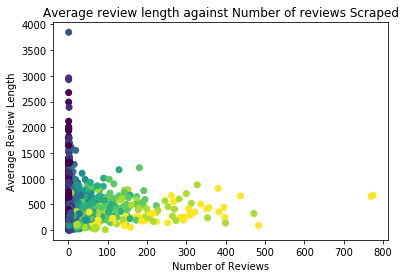

In [342]:
plt.scatter(user_reviews['Review'], 
            user_reviews['ReviewLength_avg'], 
            c=user_reviews['Reviewer_Level']) # colour by reviewer level so it's easy to see
plt.title('Average review length against Number of reviews Scraped')
plt.xlabel('Number of Reviews')
plt.ylabel('Average Review Length')
plt.show()

In [343]:
# average number of reviews
sum(user_reviews['Review']) / len(user_reviews)

10.588206062613882

In [344]:
# average review length
sum(user_reviews['ReviewLength_sum']) / sum(user_reviews['Review'])

364.208992349932

Checking out the outliers who wrote very long reviews: (If they are a minority, we shall ignore)

In [345]:
reviewlength_cutoff = 1500
longreviewers = user_reviews[user_reviews['ReviewLength_avg'] >reviewlength_cutoff].index
longreviews = df.loc[df.Reviewer.isin(user_reviews[user_reviews['ReviewLength_avg'] >1500].index),'Review']
# longreviews.reset_index().iloc[0,1] # example of a really long review

In [346]:
print(f'There are {len(longreviewers)} users with reviews longer than {reviewlength_cutoff} words on average. These reviewers wrote a total of {len(longreviews)} reviews.')

There are 28 users with reviews longer than 1500 words on average. These reviewers wrote a total of 62 reviews.


## Food
1. Food Items

In [328]:
def makeWordCloud(col, df=df):
    # create a word cloud based on a column of list items, `col` that exists inside the `df` DataFrame
    words_list = df[col].values.tolist()
    words_all = [item for sublist in words_list for item in sublist]
    wordcloud = WordCloud(background_color="white",random_state=100).generate_from_frequencies(Counter(words_all))
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return plt

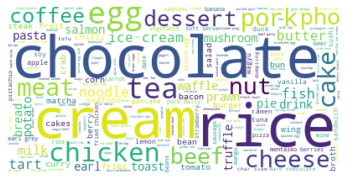

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [332]:
makeWordCloud('FoodList')

## Reviews Sentiment
- Review Content
- Review Sentiment Score

What do people say about the food? What do they say about the restaurants? What type of words do they use to describe?

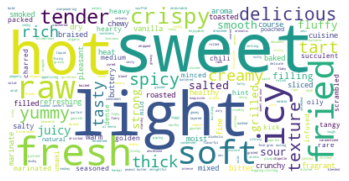

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [347]:
makeWordCloud('FoodFeatures',  user_reviews)

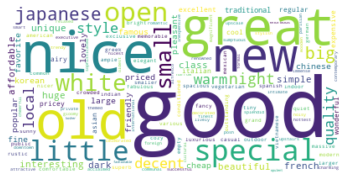

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [348]:
makeWordCloud('RestaurantFeatures',  user_reviews)

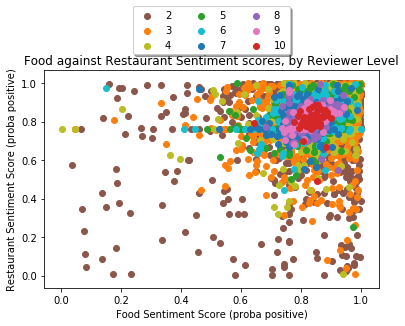

In [424]:
fig, ax = plt.subplots()
colours = ['tab:black','tab:grey', 'tab:brown', 'tab:orange','tab:olive','tab:green','tab:cyan','tab:blue','tab:purple','tab:pink','tab:red']
for color in np.arange(1.,11.):
    reviewers = user_reviews[user_reviews['Reviewer_Level']==color].index
    if len(reviewers) > 1:
        x = user_reviews.loc[reviewers, 'FoodSentimentProba']
        y = user_reviews.loc[reviewers, 'RestaurantSentimentProba']
        ax.scatter(x, y, c=colours[int(color)], label=int(color))
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.title('Food against Restaurant Sentiment scores, by Reviewer Level')
plt.xlabel('Food Sentiment Score (proba positive)')
plt.ylabel('Restaurant Sentiment Score (proba positive)')
plt.show()

This tells us that people generally write good reviews. Those with lower scores write fewer reviews - which could mean that there isn't enough data for that reviewer to give a good score, or that these minority of reviewers only write the review to complain about the food.
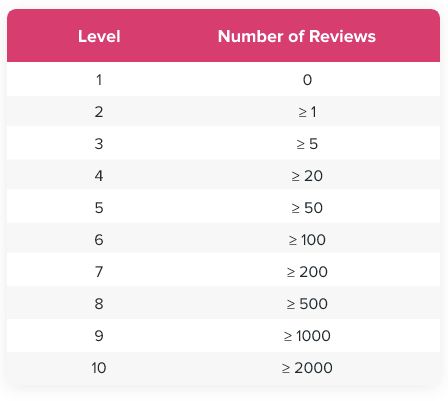

In [432]:
def seeReviews(user_list):
    return df.loc[df.Reviewer.isin(user_list),'Review']

user_poorfoodscores = user_reviews[user_reviews['FoodSentimentProba'] < 0.4].index
seeReviews(user_poorfoodscores)

719      Salmon Mentai Don!! 😍. Salmon Mentaiko Don is ...
914      Stale Fish & Bad Beef Cuts. Extremely stale fi...
2235     Flat White. Delightful! Great place for brunch...
4024     Salmon mentai Don. The 1 for 1 deal for dinner...
5478     Major Disappointment. Ordered their Under The ...
5687     Mount Omote- Premium Chirashi Don. Ordered the...
6777     Signature Grey Milk Tea - A Waste Of $ And Cal...
6788     Meh.. Meh. Had the charcoal milk tea. The drin...
7746     Bad service rude staff would not recommend. Ho...
8194     Burpple Beyond Set!. Ordered the beef sukiyaki...
8195     Huge portion! Highly Recommended. Ordered the ...
8292     Raw Food & Poor Service. I don’t think you sho...
10086    Overrated Waffles. Ordered 2 smore waffles and...
10139    Dessert At Bugis. Tried the lava cake with van...
10463    good food but slightly overpriced even with bu...
11996    Really poor service and food quality. Chirashi...
12423    Not So Fabulous Baker Boy. Terrible service. N.

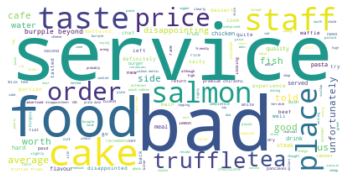

In [484]:
text = ' '.join(seeReviews(user_poorfoodscores).values)
stop_words =['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself',
            'yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself',
            'they','them','their','theirs','themselves','what','which','who','whom','this','that',
            'these','those','am','is','are','was','were','be','been','being','have','has','had',
            'having','do','does','did','doing','a','an','the','and','but','if','or','because','as',
            'until','while','of','at','by','for','with','about','against','between','into','through',
            'during','before','after','above','below','to','from','up','down','in','out','on','off',
            'over','under','again','further','then','once','here','there','when','where','why','how',
            'all','any','both','each','few','more','most','other','some','such','no','nor','not',
            'only','own','same','so','than','too','very','s','t','can','will','just','don','should',
            'now','uses','use','using','used','one','also','see','year','1','for1','a','an','the',
            'really','even','ordered','didn','used','one','also','see','year','1','for1','a','an','the']

def preprocess(data):
    reviews_tokens = []
    data = data.lower() #Convert to lower-case words
    raw_word_tokens = re.findall(r'(?:\w+)', data, flags = re.UNICODE) #remove pontuaction
    word_tokens = [w for w in raw_word_tokens if not w in stop_words] # do not add stop words
    return word_tokens

wordcloud = WordCloud(background_color="white",random_state=100).generate(' '.join(preprocess(text)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Even without doing much cleaning on the text - the most frquent word is 'bad'. Loooking at a handful of the reviews we can also see they are quite negative.